In [1]:
%matplotlib inline
import skimage
from skimage import io, color
from matplotlib import pyplot as plt
from pylab import rcParams
import numpy as np
import glob
import os
rcParams['figure.figsize'] = 10, 10

In [2]:
def show_imgs(imgs, cmap='gray'):
    for img in imgs:
        plt.figure()
        if cmap == 'gray':
            plt.imshow(img, cmap=cmap)
        else:
            plt.imshow(img)

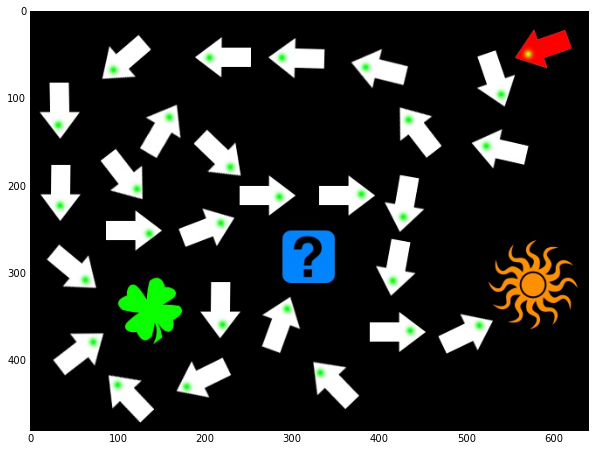

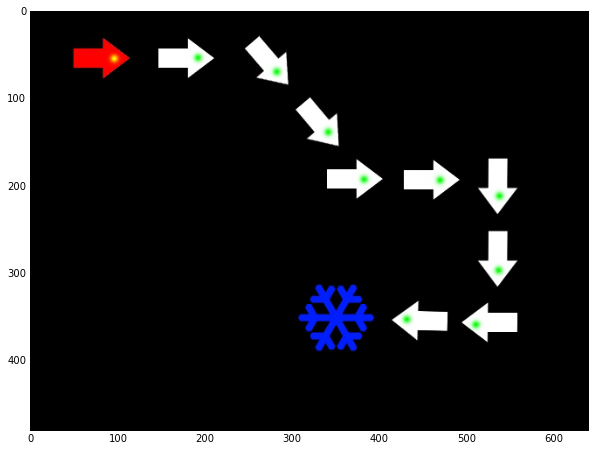

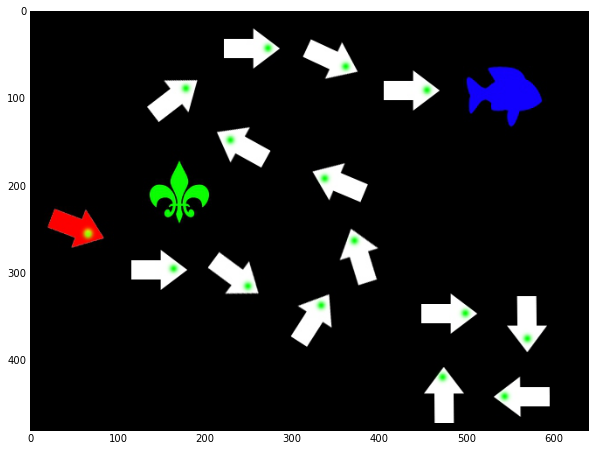

In [3]:
imgs = []
for img_name in glob.glob(os.path.join('./', '*.jpg')):
    imgs.append(skimage.io.imread(img_name))

show_imgs(imgs, cmap='rgb')

In [4]:
def binarize(img, threshold):
    return img > threshold

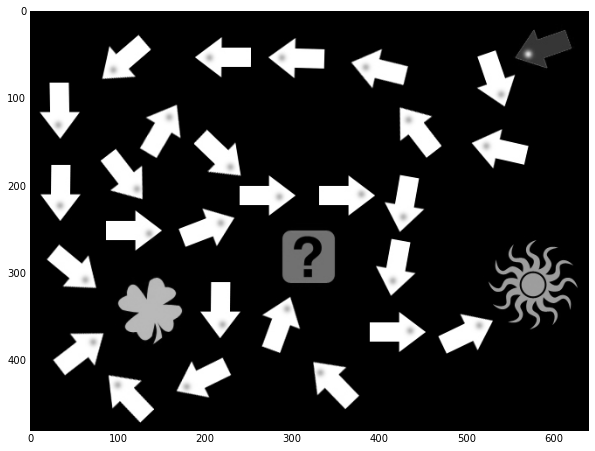

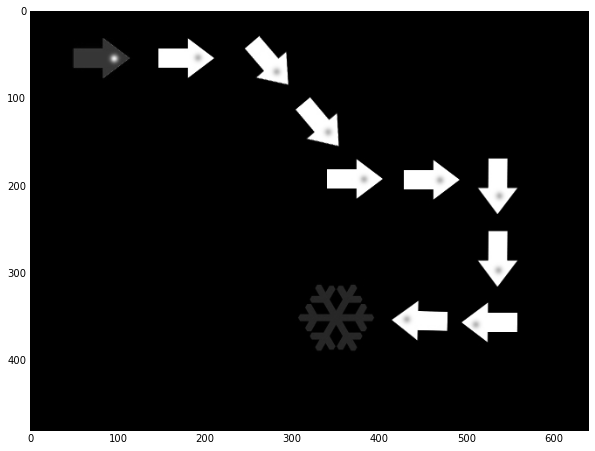

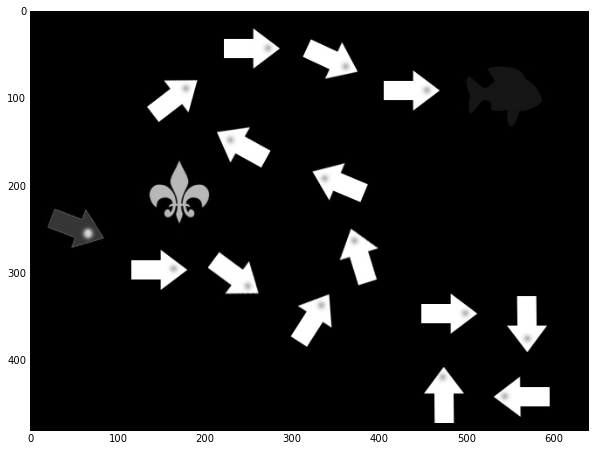

In [5]:
gray = [color.rgb2gray(img) for img in imgs]
show_imgs(gray)

Порог, который подошел, оказался равным 0.03.

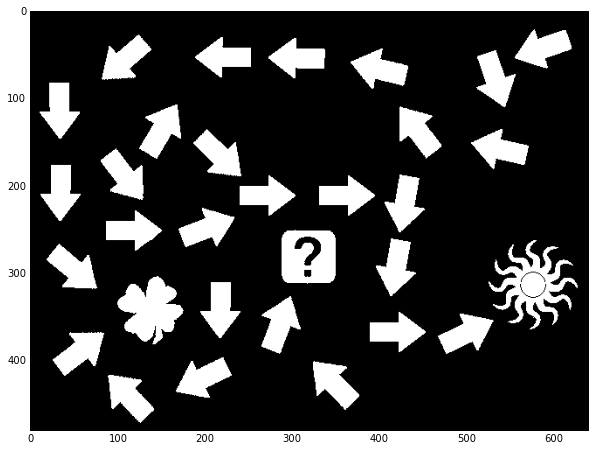

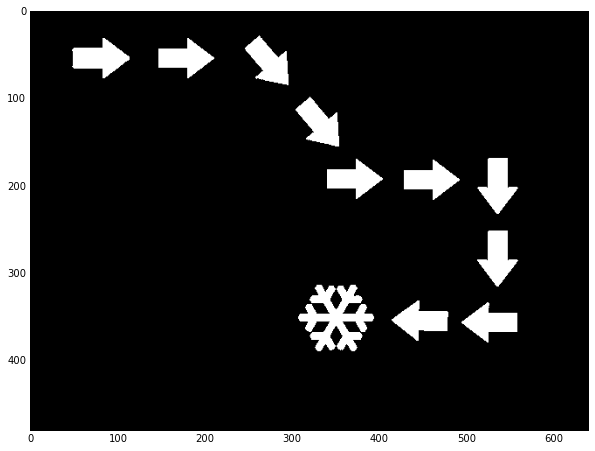

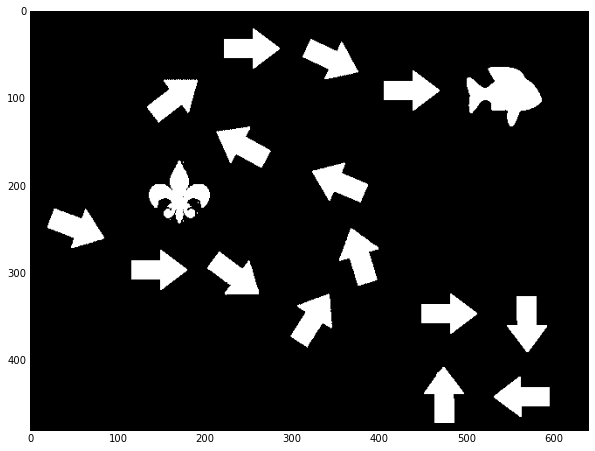

In [7]:
binarized = [binarize(img, 0.03) for img in gray]
show_imgs(binarized)

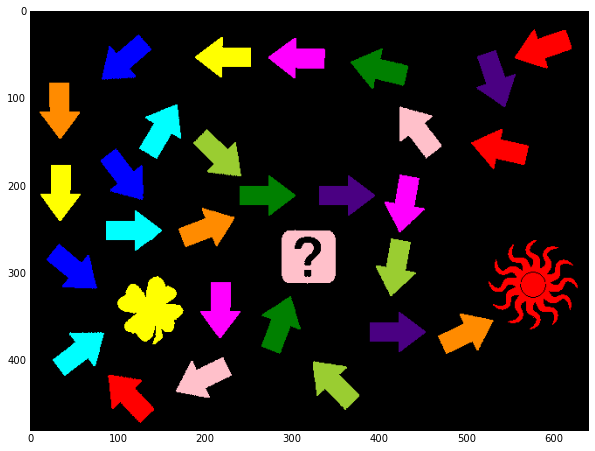

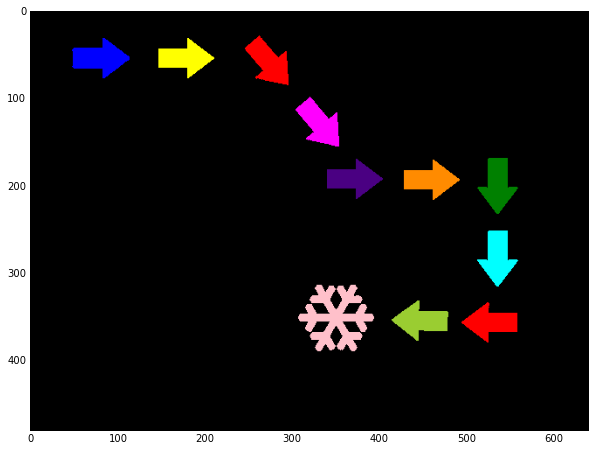

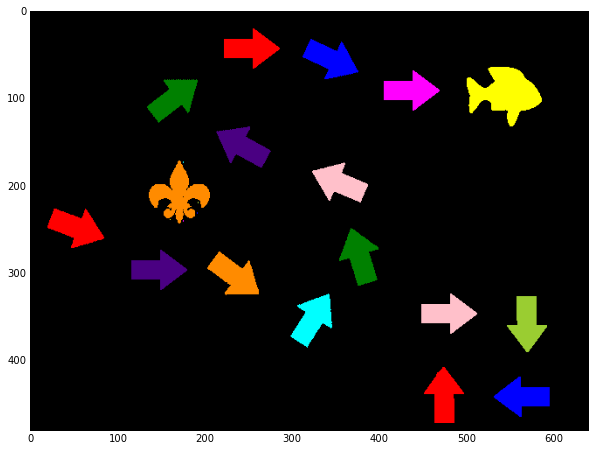

In [38]:
from skimage import measure

labeled = [measure.label(img) for img in binarized]
show_imgs([color.label2rgb(img, bg_label=200) for img in labeled], cmap='rgb')

Выделим стрелки по площади: оказалось, что все стрелки имеют площадь в диапазоне от 1400 до 1700.

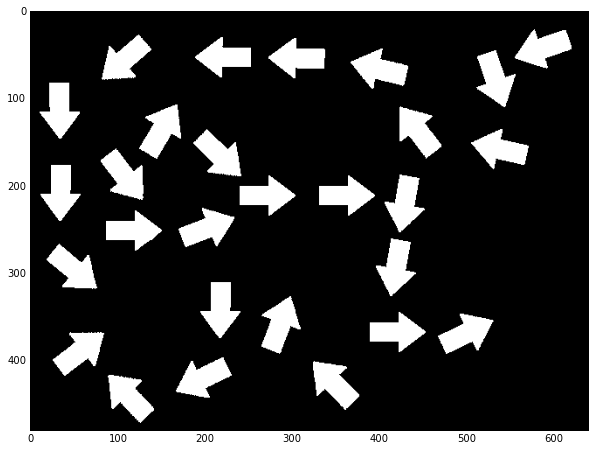

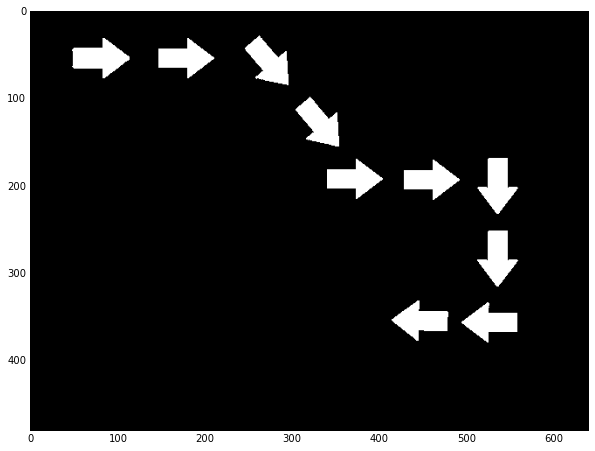

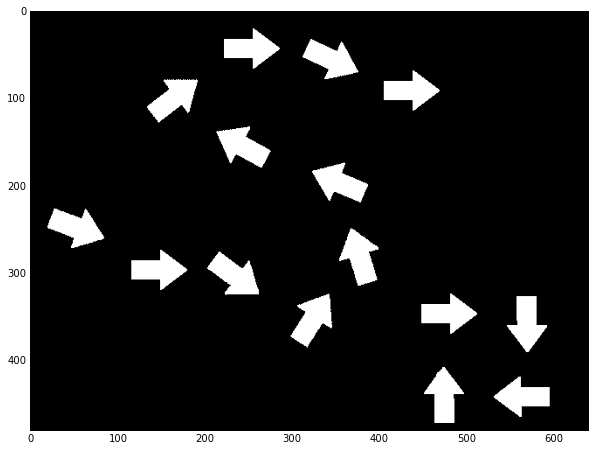

In [9]:
temp = [measure.regionprops(img) for img in labeled]
imgs_properties = []
for img in temp:
    properties = {}
    for prop in img:
        if prop.label not in properties:
            properties[prop.label] = prop
    imgs_properties.append(properties)

def is_arrow(label, area):
    if 1400 <= area <= 1700:
        return 1
    return 0

arrow_imgs = []
for ind, img in enumerate(labeled):
    height = img.shape[0]
    width = img.shape[1]
    arrowed_img = img.copy()
    for i in xrange(height):
        for j in xrange(width):
            label = img[i, j]
            if label != 0:
                area = imgs_properties[ind][label].area
                arrowed_img[i, j] = is_arrow(label, area)
    arrow_imgs.append(arrowed_img)

show_imgs(arrow_imgs)

Красные стрелки легко найти по цвету и по знанию того, что пиксель принадлежит стрелке.

In [10]:
def find_start_arrow(img, arrowed_img):
    height, width = img.shape[0], img.shape[1]
    for i in xrange(height):
        for j in xrange(width):
            if img[i, j, 0] > 250 and img[i, j, 1] < 20 and img[i, j, 2] < 20 and arrowed_img[i, j] == 1:
                return i, j

start_arrows = []
for i in xrange(len(imgs)):
    start_arrows.append(find_start_arrow(imgs[i], arrow_imgs[i]))

In [11]:
print start_arrows

[(25, 576), (35, 85), (229, 29)]


Направление стрелки можно опредедлить, как вектор, соединящий центр масс стрелки и точку, наиболее удаленную от центра масс.

In [12]:
import math

def arrow_vector(arrow_pixel, labeled_img, properties):
    label = labeled_img[arrow_pixel]
    #print label
    centroid = properties[label].centroid
    coords = properties[label].coords

    max_distance = 0
    max_distance_point = centroid
    #print coords
    for i, j in coords:
            cur_distance = math.sqrt((i - centroid[0]) ** 2 + (j - centroid[1]) ** 2)
            #print i, j, cur_distance
            if labeled_img[i, j] == label and cur_distance > max_distance:
                max_distance_point = i, j
                max_distance = cur_distance
    #print max_distance_point
    return (max_distance_point[0] - centroid[0]) / max_distance, (max_distance_point[1] - centroid[1]) / max_distance

In [13]:
def find_next_point(start_point, vector, labeled_img, arrowed_img):
    start_label = labeled_img[start_point]
    width = labeled_img
    #print vector
    for i in xrange(1, 1000):
        next_point = int(start_point[0] + i * vector[0]), int(start_point[1] + i * vector[1])
        #print next_point
        if labeled_img[next_point] != start_label and labeled_img[next_point] != 0:
            if arrowed_img[next_point] == 1:
                return next_point, 'arrow'
            else:
                return next_point, 'win'

In [14]:
def get_centroid(start_point, labeled_img, properties):
    label = labeled_img[start_point]
    centroid = properties[label].centroid
    return int(centroid[0]), int(centroid[1])

In [15]:
print find_next_point(get_centroid(start_arrows[0], labeled[0], imgs_properties[0]),
                      arrow_vector(start_arrows[0], labeled[0], imgs_properties[0]), labeled[0], arrow_imgs[0])

((58, 537), 'arrow')


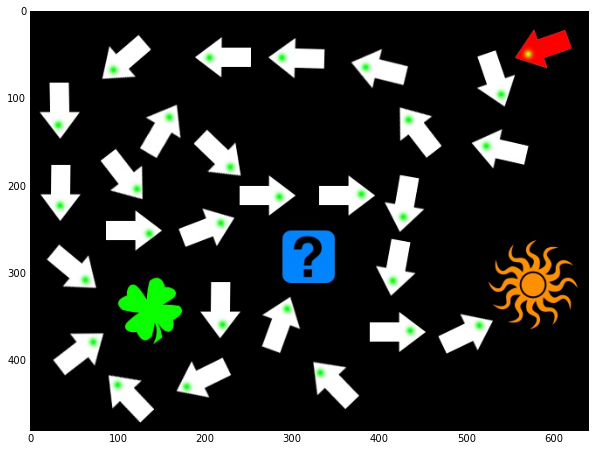

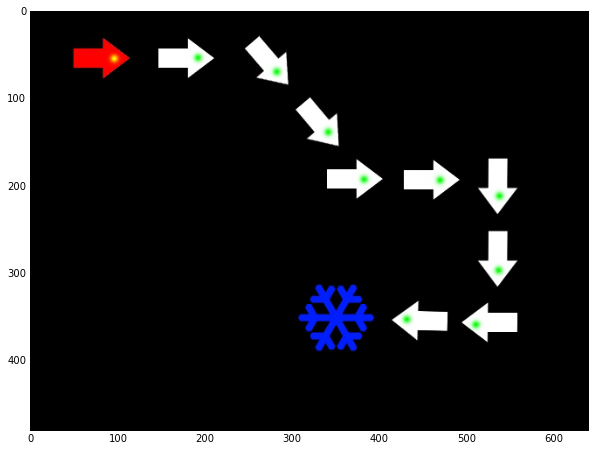

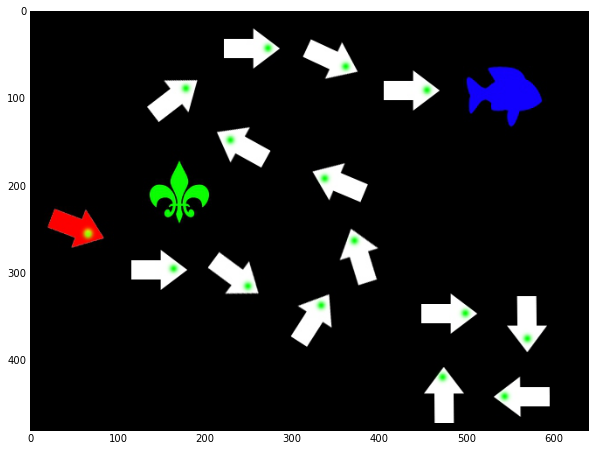

In [16]:
show_imgs(imgs, cmap='rgb')

In [30]:
print start_arrows
print get_centroid(start_arrows[0], labeled[0], imgs_properties[0])

[(25, 576), (35, 85), (229, 29)]
(42, 587)


In [33]:
label_paths = []
paths = []

for i in xrange(len(labeled)):
    labeled_img = labeled[i]
    arrowed_img = arrow_imgs[i]
    start_point = start_arrows[i]
    properties = imgs_properties[i]
    path = [(get_centroid(start_point, labeled_img, properties), 'arrow')]
    label_path = [(labeled_img[start_point], 'arrow')]
    while True:
        cur_point = path[-1][0]
        vector = arrow_vector(cur_point, labeled_img, properties)
        next_point = find_next_point(cur_point, vector, labeled_img, arrowed_img)
        next_point_coordinates = get_centroid(next_point[0], labeled_img, properties)
        path.append((next_point_coordinates, next_point[1]))
        cur_point = next_point_coordinates, next_point[1] 
        if next_point[1] == 'win':
            label_path.append((labeled_img[next_point_coordinates], 'win'))
            break
        else:
            label_path.append((labeled_img[next_point_coordinates], 'arrow'))
    label_paths.append(label_path)
    paths.append(path)

Выделим в отдельный цвет стрелки, участвующие в пути к кладу, объекты, не попавшие в путь, покрасим в цвет 2, фон в цвет 0, а клад в цвет 6.

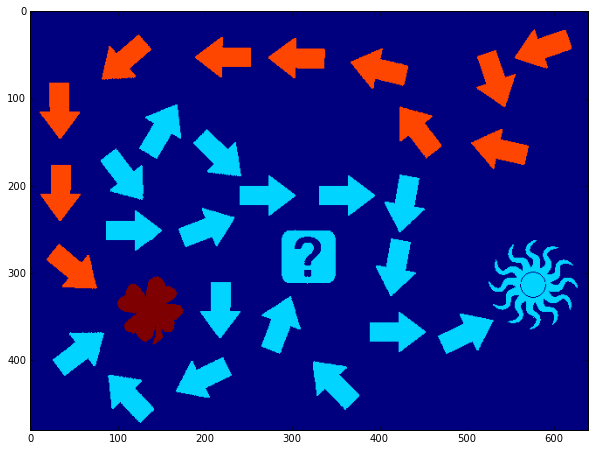

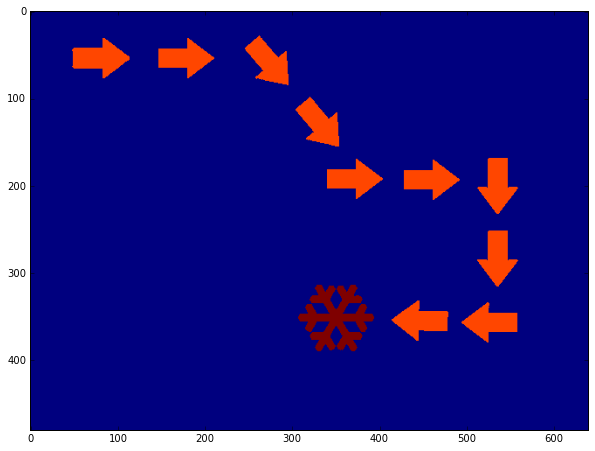

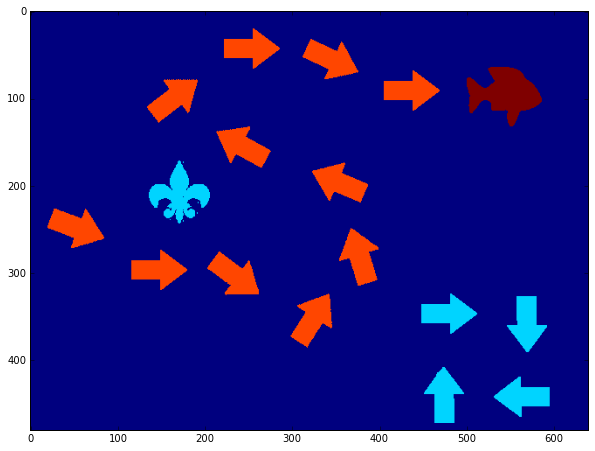

In [50]:
win_imgs = []
for ind, path in enumerate(label_paths):
    cur_img = labeled[ind].copy()
    height = cur_img.shape[0]
    width = cur_img.shape[1]
    for i in xrange(height):
        for j in xrange(width):
            in_path = False
            for label, flag in path:
                if cur_img[i, j] == label and flag == 'arrow': 
                    cur_img[i, j] = 5
                    in_path = True
                if cur_img[i, j] == label and flag == 'win':
                    cur_img[i, j] = 6
                    in_path = True
            if cur_img[i ,j] != 0 and not in_path:
                cur_img[i, j] = 2
    win_imgs.append(cur_img)

show_imgs(win_imgs, cmap='rgb')